In [1]:
import os
import yaml
import pandas as pd
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

In [2]:
import json
from triage import create_engine

with open('config/san_jose_db.json') as f:
    DB_CONFIG = json.load(f)

conn = create_engine(
    f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['pass']}@{DB_CONFIG['host']}/{DB_CONFIG['db']}"
)

In [3]:
import RecallAdjuster as ra

In [8]:
sel = """
SELECT DISTINCT model_group_id
FROM triage_metadata.model_groups
WHERE 
    model_group_id IN (61, 95, 106, 112, 115, 118)
    OR (
        model_type ILIKE '%%DecisionTree%%'
        AND (
            (hyperparameters->'max_depth')::INT < 20
            OR
            (hyperparameters->'min_samples_split')::INT < 50
        )
    )
;
"""

exclude_mgs = list(pd.read_sql(sel, conn)['model_group_id'].values)

In [15]:
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='san_jose_housing',
        schema='kit_bias_adj',
        experiment_hashes=['357e3a5bc7d3d7cfc2c13db8ea428413', 'a9bf255077d0f97c160e06761c01c637'],
        date_pairs=[('2014-06-01', '2015-06-01'), ('2015-06-01', '2016-06-01')],
        list_sizes=[500, 750, 1000],
        #entity_demos='joco',
        entity_demos='kit_bias_adj.entity_demos',
        demo_col='median_income',
        exclude_model_groups=exclude_mgs
)

Date Pair: ('2015-06-01', '2016-06-01')
List Size: 500
Metric: precision@500_abs


{'under55k_to_over55k': <matplotlib.axes._subplots.AxesSubplot at 0x7f717b01bdd8>,
 'over55k_to_under55k': <matplotlib.axes._subplots.AxesSubplot at 0x7f7178d77630>}

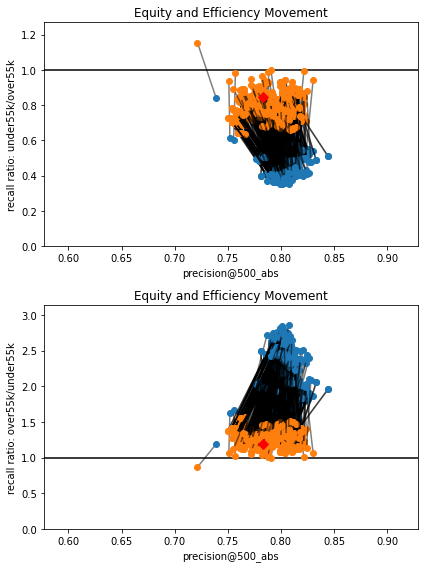

In [16]:
myRA.plot(recall_ratio='all_demos', list_size=500)

Date Pair: ('2015-06-01', '2016-06-01')
List Size: 500
Metric: precision@500_abs


(0.72, 0.85)

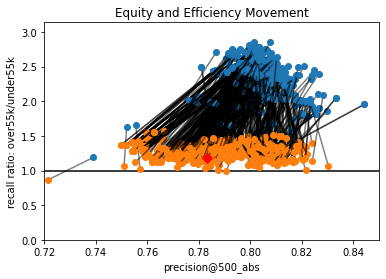

In [21]:
axd = myRA.plot(recall_ratio='over55k_to_under55k', list_size=500)

axd['over55k_to_under55k'].set_xlim((0.72,0.85))

In [24]:
import dateparser

mvmt_df = myRA.adjustment_results.loc[
            (myRA.adjustment_results['list_size'] == 500)
            &
            (myRA.adjustment_results['metric'] == 'precision@')
            &
            (myRA.adjustment_results['train_end_time'] == dateparser.parse('2016-06-01'))
            &
            (myRA.adjustment_results['past_train_end_time'] == dateparser.parse('2015-06-01'))
        ,
        ['base_value', 'base_%s' % 'recall_over55k_to_under55k', 'adj_value', 'adj_%s' % 'recall_over55k_to_under55k']
        ]

In [25]:
mvmt_df['delta_prec'] = mvmt_df['adj_value'] - mvmt_df['base_value']

mvmt_df.loc[mvmt_df['base_value'] > 0.72, ].head()

,base_value,base_recall_over55k_to_under55k,adj_value,adj_recall_over55k_to_under55k,delta_prec
36,0.739130,1.190716,0.721519,0.866335,-0.017611
39,0.752033,1.631256,0.751020,1.066106,-0.001012
42,0.755556,1.661465,0.757202,1.020614,0.001646
45,0.801223,1.824353,0.790625,1.000544,-0.010598
48,0.797468,1.848095,0.791667,1.163025,-0.005802


In [26]:
mvmt_df.loc[mvmt_df['base_value'] > 0.72, ]['delta_prec'].describe()

count    540.000000
mean      -0.017018
std        0.015164
min       -0.048646
25%       -0.029007
50%       -0.017296
75%       -0.005046
max        0.020140
Name: delta_prec, dtype: float64

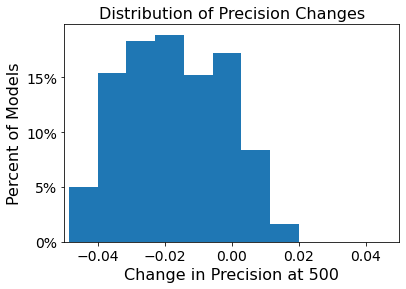

In [28]:
from matplotlib.ticker import PercentFormatter
import numpy as np

ax = mvmt_df.loc[mvmt_df['base_value'] > 0.72, ]['delta_prec'].plot.hist(bins=8, xlim=(-0.05,0.05), 
                                                                        weights=np.ones(540) / 540)

ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_title('Distribution of Precision Changes', fontsize=16)
ax.set_xlabel('Change in Precision at 500', fontsize=16)
ax.set_ylabel('Percent of Models', fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

Unlike JoCo, it looks like there is a little bit of precision lost, but like LA, very, very modest (average 1.7pp in precision for models with Precision@500 of nearly 80%)

# Full Set of Dates
As above, using a 1-year lookback for adjustments since I'm using a 1-year test label window here to ensure a reasonable amount of labeled examples in the test set...

In [13]:
import datetime
from dateutil.relativedelta import relativedelta
base = datetime.datetime.strptime('2016-06-01', '%Y-%m-%d')
date_pairs = []
for x in range(17,-1,-1):
    date_pairs.append(
        (
        (base - relativedelta(months=3*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=3*x) - relativedelta(years=1)).strftime('%Y-%m-%d')
        )
    )
    date_pairs.append(
        (
        (base - relativedelta(months=3*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=3*x)).strftime('%Y-%m-%d')
        )
    )

In [14]:
conn.dispose()
conn = create_engine(
    f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['pass']}@{DB_CONFIG['host']}/{DB_CONFIG['db']}"
)

myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='postgres',
        schema='hemank_bias_orig',
        #experiment_hashes=['357e3a5bc7d3d7cfc2c13db8ea428413', 'a9bf255077d0f97c160e06761c01c637'],
        experiment_hashes=['9dcafc4760c3618bfae96a54a4359481'],
        date_pairs=date_pairs,
        list_sizes=[500, 750, 1000],
        #entity_demos='joco',
        entity_demos='kit_bias_adj.entity_demos',
        demo_col='median_income',
        exclude_model_groups=exclude_mgs
)

In [15]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM kit_bias_adj.model_adjustment_results_median_income
  WHERE past_train_end_time = train_end_time
        AND list_size = 500
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_over55k_to_under55k AS recall_over55k_to_under55k,
       r.base_frac_over55k AS frac_over55k,
       r.base_frac_under55k AS frac_under55k
FROM kit_bias_adj.model_adjustment_results_median_income r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
        AND r.list_size = 500

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_over55k_to_under55k AS recall_over55k_to_under55k,
       r.adj_frac_over55k AS frac_over55k,
       r.adj_frac_under55k AS frac_under55k
FROM kit_bias_adj.model_adjustment_results_median_income r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
        AND r.list_size = 500

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_over55k_to_under55k AS recall_over55k_to_under55k,
       r.adj_frac_over55k AS frac_over55k,
       r.adj_frac_under55k AS frac_under55k
FROM kit_bias_adj.model_adjustment_results_median_income r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
        AND r.list_size = 500

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_over55k_to_under55k,
      frac_over55k,
      frac_under55k
FROM kit_bias_adj.composite_results_median_income
WHERE train_end_time > past_train_end_time
        AND list_size = 500
;
"""

In [16]:
ts_df3 = pd.read_sql(sql, conn)

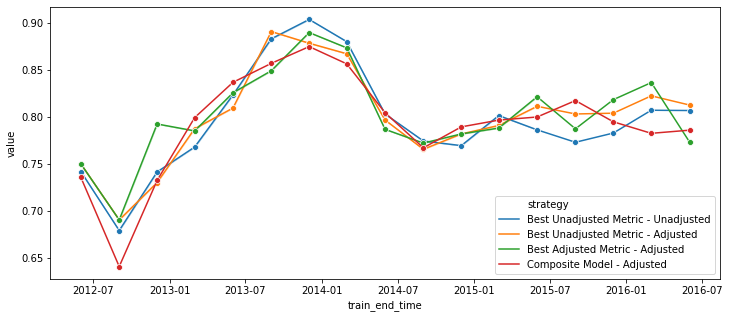

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

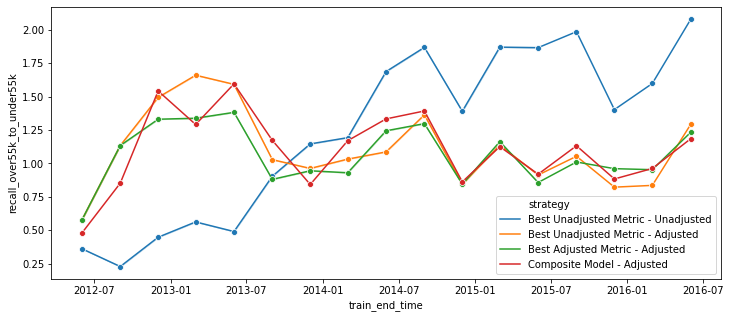

In [18]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='recall_over55k_to_under55k', hue='strategy', marker="o", ax=ax)

It looks like in the first couple years of the series, there's a lot more variance, probably a combination of fewer training labels before this point (we're trying to go back 6 years, so quickly running into the end of the series) and the change in policy around the "tier" system that was introduced in the middle, potentially making the prediction problem harder across this boundary. It's interesting that the underlying bias seems to switch over this time, though note that the recall adjustments do appear to continue to pull towards 1 on both sides of this switch...

Let's just take a look at the more stable recent period where the second end time is after June 2014 (so the adjustements are being made based on June 2013):

In [39]:
ts_df3 = ts_df3.loc[ts_df3['train_end_time'] >= '2014-06-01', ]

In [49]:
import matplotlib.dates as mdates

months = mdates.MonthLocator([3,6,9,12])  # every month
months_fmt = mdates.DateFormatter('%b %y')

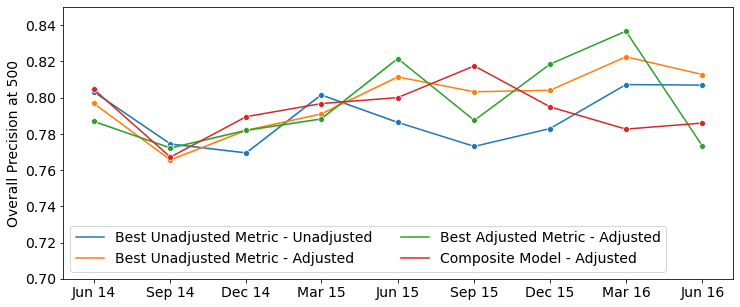

In [51]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.7,0.85))
ax.set_ylabel('Overall Precision at 500', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=2, fontsize=14)


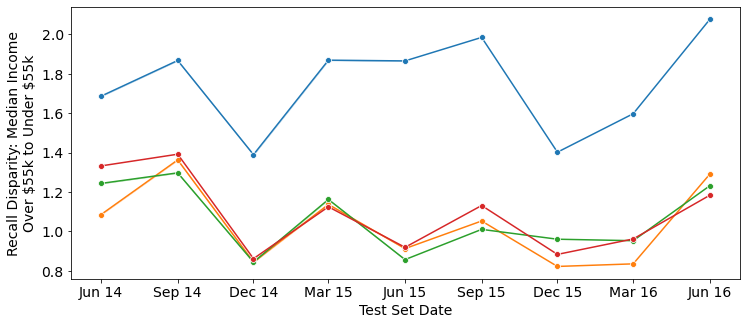

In [53]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='recall_over55k_to_under55k', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity: Median Income\nOver \$55k to Under \$55k', fontsize=14)
ax.set_xlabel('Test Set Date', fontsize=14)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.get_legend().remove()


(0.7, 0.85)

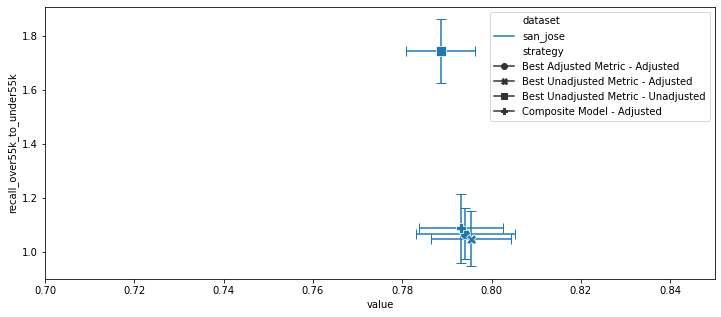

In [46]:
ts_df3['dataset'] = 'san_jose'

fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3.groupby(['dataset', 'strategy'])[['value', 'recall_over55k_to_under55k']].mean().reset_index(), 
              x='value', y='recall_over55k_to_under55k', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


x_coords = list(ts_df3.groupby(['dataset', 'strategy'])[['value', 'recall_over55k_to_under55k']].mean().reset_index()['value'].values)
y_coords = list(ts_df3.groupby(['dataset', 'strategy'])[['value', 'recall_over55k_to_under55k']].mean().reset_index()['recall_over55k_to_under55k'].values)

prec_errors = 1.96*ts_df3.groupby(['dataset', 'strategy'])['value'].sem().values
disp_errors = 1.96*ts_df3.groupby(['dataset', 'strategy'])['recall_over55k_to_under55k'].sem().values
colors = sns.color_palette().as_hex()[0]
ax.errorbar(x_coords, y_coords, 
            xerr=prec_errors, 
            yerr=disp_errors,
    ecolor=colors, 
    fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.70,0.85))

This story feels pretty consistent with what we've seen in other datasets. Two observations:

1. Interesting that the slight decrease in precision actually isn't seen here in aggregate, but perhaps reflects variance in model performance across selection criteria outweighing that slight drop.
2. Unlike some of the other datasets, the composite's performance is actually comparable to the others, which is particularly surprising given the selective labels problem here. That said, We are using a relatively larger list size (there are only a few thousand entities overall) -- though it does reflect the actual SJ capacity, this might mean we're further out towards the tail observed in JoCo where things start to converge. Could explore list size here more at some point, but might run into a lot of noise with the selective labels issues.

In [47]:
# pickle a few things for future use / figure creation

import pickle

myRA.engine.close()
myRA.engine = None

dump_dict = {
    'recall_adj_obj': myRA,
    'plot_df': ts_df3
}

pickle.dump(dump_dict, open('sj_figs_20200531_objects.pkl', 'wb'))

In [54]:
ts_df3.head()

,strategy,train_end_time,past_train_end_time,list_size,metric,parameter,value,max_recall_ratio,recall_over55k_to_under55k,frac_over55k,frac_under55k,dataset
16,Best Unadjusted Metric - Unadjusted,2014-06-01,2013-06-01,500,precision@,500_abs,0.803213,1.686948,1.686948,0.614,0.386,san_jose
17,Best Unadjusted Metric - Unadjusted,2014-06-01,2013-06-01,500,precision@,500_abs,0.803213,1.686948,1.686948,0.614,0.386,san_jose
18,Best Unadjusted Metric - Unadjusted,2014-09-01,2013-09-01,500,precision@,500_abs,0.774436,1.867981,1.867981,0.632,0.368,san_jose
19,Best Unadjusted Metric - Unadjusted,2014-09-01,2013-09-01,500,precision@,500_abs,0.774436,1.867981,1.867981,0.632,0.368,san_jose
20,Best Unadjusted Metric - Unadjusted,2014-12-01,2013-12-01,500,precision@,500_abs,0.769504,1.389994,1.389994,0.650,0.350,san_jose


In [58]:
exp_df = ts_df3.rename(
    {'recall_over55k_to_under55k': 'recall_disp', 
     'frac_over55k': 'frac_grp1', 
     'frac_under55k': 'frac_grp2'
    }, axis='columns')


In [59]:
exp_df.head()

,strategy,train_end_time,past_train_end_time,list_size,metric,parameter,value,max_recall_ratio,recall_disp,frac_grp1,frac_grp2,dataset
16,Best Unadjusted Metric - Unadjusted,2014-06-01,2013-06-01,500,precision@,500_abs,0.803213,1.686948,1.686948,0.614,0.386,san_jose
17,Best Unadjusted Metric - Unadjusted,2014-06-01,2013-06-01,500,precision@,500_abs,0.803213,1.686948,1.686948,0.614,0.386,san_jose
18,Best Unadjusted Metric - Unadjusted,2014-09-01,2013-09-01,500,precision@,500_abs,0.774436,1.867981,1.867981,0.632,0.368,san_jose
19,Best Unadjusted Metric - Unadjusted,2014-09-01,2013-09-01,500,precision@,500_abs,0.774436,1.867981,1.867981,0.632,0.368,san_jose
20,Best Unadjusted Metric - Unadjusted,2014-12-01,2013-12-01,500,precision@,500_abs,0.769504,1.389994,1.389994,0.650,0.350,san_jose


In [60]:
pickle.dump(exp_df, open('sj_figs_20200531_exp_df.pkl', 'wb'))

In [62]:
exp_df.to_csv('sj_figs_20200531_exp_df.csv', index=False)